# CartoBlobPy Demo
This notebook shows how to load a map from the assets and check whether a straight line between two world points collides with obstacles using `Graph.is_free_path`.

In [5]:
# Setup: add repo root to Python path and import package
import sys, os
sys.path.append("../src")
from cartoblobpy.graph import Graph
from cartoblobpy.assets.__assets import get_map_path, list_example_maps

In [6]:
# Load a sample map from assets
available = list_example_maps()
print("Available maps:", available)
map_name = available[0] if available else 'map005.yaml'
yaml_path = get_map_path(map_name)
print("Using map:", yaml_path)

g = Graph()
g.load_from_yaml(yaml_path)
print("Resolution (m/px):", g.resolution)
print("Origin [x,y,yaw]:", g.origin.tolist())
print("Grid size (rows, cols):", g.grid.shape)

# Optional: obstacle inflation for smoother clearance (radius in px)
g.inflate_obstacles(radius=2)

Available maps: ['map002.yaml', 'map004.yaml', 'map005.yaml', 'map006.yaml', 'map007.yaml', 'map008.yaml', 'map009.yaml', 'map010.yaml', 'map011.yaml', 'map012.yaml', 'map013.yaml', 'map014.yaml', 'map015.yaml']
Using map: C:\Users\emirc\OneDrive - NTNU\Projects\image_to_map\cartoblobpy\src\cartoblobpy\assets\map002.yaml
Resolution (m/px): 0.1
Origin [x,y,yaw]: [0.0, 0.0, 0.0]
Grid size (rows, cols): (200, 200)


In [7]:
# Collision check between two world points
import numpy as np

# Define two points in world coordinates [x, y]
p1 = np.array([0.5, 0.5])
p2 = np.array([g.real_width - 0.5, g.real_height - 0.5])

is_free = g.is_free_path(p1, p2)
print(f"Line from {p1} to {p2} is {'FREE' if is_free else 'BLOCKED'}.")

Line from [0.5 0.5] to [19.5 19.5] is FREE.


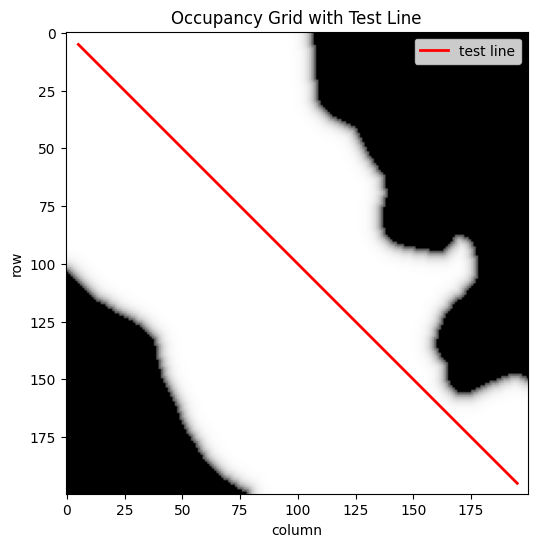

In [8]:
# Optional visualization of the occupancy grid and the tested line
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(g.grid, cmap='gray_r', origin='upper')

# Convert world points to grid for plotting
pg1 = g.world_to_grid(p1)
pg2 = g.world_to_grid(p2)
ax.plot([pg1[1], pg2[1]],[pg1[0], pg2[0]],'r-', linewidth=2, label='test line')
ax.set_title('Occupancy Grid with Test Line')
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.legend()
plt.show()